In [1]:
import scanpy as sc
import squidpy as sq
import numpy as np
import pandas as pd
from anndata import AnnData
import pathlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import skimage
import seaborn as sns
import tangram as tg

/home/wout/mambaforge/envs/tangram-env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Import the scRNA/snRNA data from the liver cell atlas
ad_sc = sc.read('/home/wout/Documents/Thesis_lokaal/Data_to_create_liver_atlas/adataAtlasFull.h5ad')
ad_sc=ad_sc[ad_sc.obs.typeSample=='nucSeq'] # Sparrow data was also set to 'nucleus', so makes sense to only use 'nucleus' single cell sources  
# Import the spatial data (Resolve MERFISH), this is the cell/gene matrix generated with the Sparrow pipeline   
ad_sp=sc.read('/home/wout/Documents/Thesis_lokaal/Mouse_Liver_Resolve_Data/adataNucA1-1.h5ad')
ad_sp.X=ad_sp.raw.X # Because the spatial data was normalized, to remove this

In [3]:
ad_sp

AnnData object with n_obs × n_vars = 11043 × 98
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_2_genes', 'pct_counts_in_top_5_genes', 'n_counts', 'nucleusSize', 'leiden', 'portal_vein_EC45', 'LSEC45', 'central_vein_EC45', 'stellate45', 'fibroblast45', 'capsular_fibroblasts45', 'Hepatocytes', 'Cholangiocytes', 'cDC2s', 'Mig. cDCs', 'Monocytes and Monocytes-derived cells', 'Neutrophils', 'Basophils', 'NK cells', 'ILC1s', 'T cells', 'pDCs', 'B cells', 'cDC1s', 'Kupffer cells', 'Cleanliness', 'maxScores', 'Hep', 'maxScoresSave'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'mean', 'std'
    uns: 'leiden', 'leiden_colors', 'maxScores_colors', 'neighbors', 'pca', 'rank_genes_groups', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [4]:
ad_sp.to_df().head

<bound method NDFrame.head of genes   Acta2  Adamtsl2  Adgre1  Adgrg6  Atp6v0d2  Axl  C5ar1  Ccr2  Ccr7  \
cellsR                                                                      
1         0.0       0.0     0.0     0.0       0.0  0.0    0.0   0.0   0.0   
2         0.0       0.0     0.0     0.0       1.0  0.0    0.0   0.0   0.0   
3         0.0       0.0     0.0     0.0       0.0  0.0    0.0   0.0   0.0   
4         0.0       0.0     0.0     0.0       0.0  0.0    0.0   0.0   0.0   
5         0.0       0.0     0.0     0.0       0.0  0.0    0.0   0.0   0.0   
...       ...       ...     ...     ...       ...  ...    ...   ...   ...   
11297     0.0       0.0     0.0     0.0       0.0  0.0    0.0   0.0   0.0   
11298     0.0       0.0     0.0     0.0       0.0  0.0    0.0   0.0   0.0   
11300     0.0       0.0     0.0     0.0       0.0  0.0    0.0   0.0   0.0   
11301     0.0       0.0     0.0     0.0       0.0  0.0    0.0   0.0   0.0   
11305     0.0       0.0     0.0     0.0       

In [5]:
ad_sc

View of AnnData object with n_obs × n_vars = 18666 × 31053
    obs: 'annot', 'typeSample', 'cluster_orig'
    obsm: 'X_umap'

In [6]:
ad_sc.to_df()

genes,Xkr4,Gm1992,Gm37381,Rp1,Sox17,Gm37323,Mrpl15,Lypla1,Gm37988,Tcea1,...,AC125149.1,AC125149.2,AC125149.4,AC234645.1,AC168977.2,AC168977.1,AC149090.1,CAAA01118383.1,Vmn2r122,CAAA01147332.1
cells,,,,,,,,,,,,,,,,,,,,,
AATGGCTTCCTGTACC-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
AGTCAACAGAACAAGG-27,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CTACTATAGGCTGGAT-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
CTCAACCTCAAGCTTG-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
GAGTTACAGCCTCATA-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTATGCTCGCTAATG-38,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AACCACAGTACGCTAT-38,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
AACTTCTAGATACAGT-38,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
np.unique(ad_sc.obs["annot"].tolist())

array(['B cells', 'Basophils', 'Cholangiocytes', 'Endothelial cells',
       'Fibroblasts', 'Hepatocytes', 'HsPCs', 'ILC1s', 'Kupffer cells',
       'Mig. cDCs', 'Monocytes & Monocyte-derived cells', 'NK cells',
       'Neutrophils', 'T cells', 'cDC1s', 'cDC2s'], dtype='<U34')

In [8]:
tg.pp_adatas(ad_sc,ad_sp) # if 'genes' is not specified then all genes are used

INFO:root:97 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:97 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.


In [9]:
ad_map = tg.map_cells_to_space(ad_sc,ad_sp,
    mode="cells",
    density_prior='uniform', # spatial voxels are at single cell resolution --> must be set to 'uniform'
    num_epochs=500,
    device='cpu',) 


INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 97 genes and uniform density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.210, KL reg: 0.000
Score: 0.972, KL reg: 0.003
Score: 0.979, KL reg: 0.002
Score: 0.981, KL reg: 0.002
Score: 0.982, KL reg: 0.001


INFO:root:Saving results..


In [10]:
ad_map

AnnData object with n_obs × n_vars = 18666 × 11043
    obs: 'annot', 'typeSample', 'cluster_orig'
    var: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_2_genes', 'pct_counts_in_top_5_genes', 'n_counts', 'nucleusSize', 'leiden', 'portal_vein_EC45', 'LSEC45', 'central_vein_EC45', 'stellate45', 'fibroblast45', 'capsular_fibroblasts45', 'Hepatocytes', 'Cholangiocytes', 'cDC2s', 'Mig. cDCs', 'Monocytes and Monocytes-derived cells', 'Neutrophils', 'Basophils', 'NK cells', 'ILC1s', 'T cells', 'pDCs', 'B cells', 'cDC1s', 'Kupffer cells', 'Cleanliness', 'maxScores', 'Hep', 'maxScoresSave', 'uniform_density', 'rna_count_based_density'
    uns: 'train_genes_df', 'training_history'

In [11]:
ad_map.to_df()

cellsR,1,2,3,4,5,6,7,8,9,10,...,11292,11293,11294,11295,11296,11297,11298,11300,11301,11305
cells,,,,,,,,,,,,,,,,,,,,,
AATGGCTTCCTGTACC-27,1.244453e-05,1.433770e-04,1.346501e-05,1.079884e-05,1.227417e-06,5.843935e-06,7.019362e-05,1.521804e-05,2.557449e-06,6.951118e-06,...,2.147360e-05,1.070646e-04,3.472161e-06,1.000432e-05,4.751860e-06,5.965058e-06,1.464507e-06,1.874254e-06,1.871354e-05,6.470731e-06
AGTCAACAGAACAAGG-27,3.041483e-04,3.830497e-05,1.737889e-05,2.355941e-05,3.396744e-05,3.803052e-05,1.183122e-05,1.184482e-05,2.548675e-05,3.832711e-05,...,3.330217e-06,1.136988e-05,2.062948e-05,6.706348e-06,6.108631e-05,1.689526e-05,3.296830e-05,4.693908e-05,1.618208e-05,4.842244e-05
CTACTATAGGCTGGAT-27,7.689798e-06,1.263622e-05,7.336694e-07,3.610207e-06,1.794105e-06,1.954754e-06,2.946660e-05,3.518105e-06,6.252063e-07,9.892520e-06,...,4.723061e-06,4.673185e-06,3.759094e-06,1.839529e-05,1.162702e-06,1.696355e-06,1.693941e-06,6.408800e-06,3.514638e-06,9.472708e-07
CTCAACCTCAAGCTTG-27,2.242706e-06,1.687516e-06,4.011590e-05,5.683755e-06,2.196385e-05,8.853731e-05,2.682219e-07,3.676069e-06,1.492719e-05,6.420886e-05,...,1.507267e-05,1.544892e-06,3.060780e-06,2.248888e-06,1.600368e-05,6.881425e-06,1.242044e-06,4.183575e-06,2.783196e-06,4.513848e-06
GAGTTACAGCCTCATA-27,9.855581e-07,1.471519e-07,8.746813e-07,1.345509e-06,1.161648e-06,1.610434e-05,9.791147e-07,2.030772e-06,5.785129e-07,1.421376e-06,...,2.125865e-07,7.397769e-07,6.816275e-07,3.321925e-06,1.513218e-06,5.181243e-07,2.098193e-06,4.817448e-07,2.562153e-07,1.312749e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTATGCTCGCTAATG-38,4.015690e-05,2.017188e-05,6.164085e-06,1.450106e-05,6.730866e-06,7.345053e-06,9.379864e-06,1.153362e-05,9.495066e-06,2.020569e-05,...,5.331357e-06,1.406356e-05,4.280774e-06,1.372386e-05,4.902286e-06,5.754558e-06,1.150186e-05,1.254981e-05,2.144605e-05,2.538006e-05
AACCACAGTACGCTAT-38,8.391447e-07,2.498323e-06,4.962223e-07,1.547447e-06,1.978010e-07,9.795692e-07,5.600153e-07,2.562314e-07,4.447121e-08,2.514915e-07,...,2.309679e-06,1.840393e-07,4.313031e-07,1.625333e-07,3.891767e-07,1.417318e-06,7.816499e-07,7.896586e-07,8.417017e-08,1.034377e-06
AACTTCTAGATACAGT-38,1.948036e-06,3.723445e-07,1.312153e-06,8.820007e-07,2.305545e-07,1.153533e-06,7.424620e-07,5.657113e-07,8.358243e-08,5.192615e-07,...,4.491197e-06,1.248592e-06,2.082030e-06,9.739339e-07,1.699494e-06,5.776366e-06,2.400558e-06,7.057970e-07,1.187659e-06,1.365698e-06


In [12]:
tg.project_cell_annotations(ad_map, ad_sp, annotation="annot")
cell_types = np.unique(ad_sc.obs["annot"].tolist())

INFO:root:spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.


In [13]:
# tg.plot_cell_annotation_sc(ad_sp,cell_types,perc=0.02)
# plot fails?

In [14]:
ad_sp.obsm['tangram_ct_pred']

,Fibroblasts,Endothelial cells,Hepatocytes,Cholangiocytes,NK cells,B cells,Monocytes & Monocyte-derived cells,Kupffer cells,cDC1s,HsPCs,T cells,ILC1s,Basophils,Mig. cDCs,cDC2s,Neutrophils
cellsR,,,,,,,,,,,,,,,,
1,0.664679,0.018325,0.937040,0.036607,0.000010,0.001202,0.000144,0.001727,0.000572,0.006501,0.000379,0.000008,0.000003,0.000144,0.000180,0.000012
2,0.040113,0.007022,1.428030,0.003979,0.000011,0.001024,0.000142,0.001808,0.000489,0.191086,0.000252,0.000011,0.000010,0.000151,0.000192,0.000017
3,0.409038,0.007689,1.219530,0.004853,0.000010,0.001134,0.000141,0.002962,0.000864,0.017602,0.000488,0.000012,0.000004,0.000140,0.000261,0.000010
4,0.098782,0.007730,1.365555,0.124304,0.000016,0.000929,0.000096,0.001601,0.000578,0.073408,0.000302,0.000009,0.000010,0.000181,0.000261,0.000010
5,0.672288,0.005251,0.970517,0.003612,0.000013,0.001106,0.000114,0.001767,0.000528,0.014721,0.000304,0.000013,0.000005,0.000140,0.000216,0.000028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11297,0.449347,0.040521,1.079277,0.012420,0.000013,0.001304,0.000221,0.002178,0.000631,0.076714,0.000366,0.000010,0.000009,0.000142,0.000291,0.000009
11298,0.557576,0.810836,0.157054,0.109397,0.000016,0.001131,0.000142,0.002644,0.000452,0.025766,0.000422,0.000010,0.000005,0.000166,0.000220,0.000008
11300,0.998917,0.189539,0.211840,0.061872,0.000012,0.001946,0.000138,0.002912,0.000725,0.192162,0.003722,0.000009,0.000009,0.000146,0.000284,0.000008


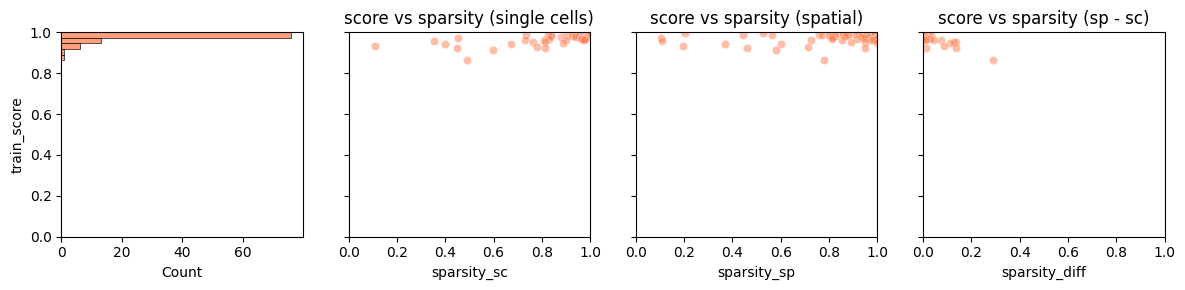

In [15]:
# How well do the counts of the mapped cell correspond with the measured counts in the spatial data (cosine similarity)
# Done for each training gene
tg.plot_training_scores(ad_map, bins=5, alpha=.5)

In [16]:
ad_map.uns['train_genes_df']

,train_score,sparsity_sc,sparsity_sp,sparsity_diff
spn,0.999902,0.999089,0.971747,-0.027342
mmp12,0.999741,0.998446,0.808838,-0.189608
cd3e,0.999722,0.998982,0.976637,-0.022345
chil3,0.999684,0.999786,0.992212,-0.007573
ccr7,0.999618,0.999089,0.983247,-0.015842
...,...,...,...,...
mafb,0.930053,0.779599,0.711854,-0.067746
cyp2e1,0.922943,0.447177,0.460473,0.013296
nrxn1,0.922337,0.812600,0.948927,0.136326
slc40a1,0.911739,0.598468,0.581364,-0.017104


In [17]:
# Spatial gene expression off all genes based on prediction (mapping)
ad_ge = tg.project_genes(adata_map=ad_map, adata_sc=ad_sc)
ad_ge 

AnnData object with n_obs × n_vars = 11043 × 24212
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_2_genes', 'pct_counts_in_top_5_genes', 'n_counts', 'nucleusSize', 'leiden', 'portal_vein_EC45', 'LSEC45', 'central_vein_EC45', 'stellate45', 'fibroblast45', 'capsular_fibroblasts45', 'Hepatocytes', 'Cholangiocytes', 'cDC2s', 'Mig. cDCs', 'Monocytes and Monocytes-derived cells', 'Neutrophils', 'Basophils', 'NK cells', 'ILC1s', 'T cells', 'pDCs', 'B cells', 'cDC1s', 'Kupffer cells', 'Cleanliness', 'maxScores', 'Hep', 'maxScoresSave', 'uniform_density', 'rna_count_based_density'
    var: 'n_cells', 'sparsity', 'is_training'
    uns: 'training_genes', 'overlap_genes'

In [18]:
# Predicted expression of all genes based on mapped single cell data  
ad_ge.to_df().head()

,xkr4,gm1992,gm37381,rp1,sox17,mrpl15,lypla1,gm37988,tcea1,rgs20,...,ac132444.1,ac132444.5,csprs,ac132444.6,ac125149.3,ac168977.2,ac168977.1,ac149090.1,caaa01118383.1,caaa01147332.1
cellsR,,,,,,,,,,,,,,,,,,,,,
1,0.180821,0.000398,0.000039,0.000392,0.003308,0.362405,0.000078,0.077641,0.164205,0.000833,...,0.000013,0.004841,0.000535,6.385113e-08,0.000285,0.000024,0.000058,2.051690,0.104323,0.000339
2,1.046510,0.000211,0.000047,0.006877,0.004100,0.737528,0.000074,0.436023,0.218415,0.089244,...,0.000018,0.000053,0.001762,1.883028e-07,0.000295,0.000026,0.000046,4.933492,0.424085,0.000109
3,0.460194,0.000189,0.000065,0.000275,0.009784,0.107337,0.000180,0.052516,0.126488,0.001774,...,0.000021,0.000142,0.000474,1.027584e-07,0.000434,0.000021,0.000074,3.127292,0.188269,0.000144
4,0.327700,0.000170,0.000033,0.049711,0.070615,1.121156,0.000149,0.220219,0.187780,0.041123,...,0.000011,0.000103,0.000500,1.810143e-07,0.000521,0.000027,0.000022,8.841138,0.229305,0.000080
5,0.059705,0.000185,0.000036,0.000321,0.007546,0.826255,0.000121,0.101147,0.273952,0.000675,...,0.000013,0.000077,0.000359,1.077682e-07,0.000263,0.000017,0.000101,6.015578,1.227921,0.000201


In [19]:
# Measured expression of training genes based on mapped single cell data  
ad_sp.to_df().head()

,acta2,adamtsl2,adgre1,adgrg6,atp6v0d2,axl,c5ar1,ccr2,ccr7,cd14,...,svep1,timd4,tmem119,trem2,vsig4,vwf,wnt2,wnt9b,wt1,xcr1
cellsR,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
genes = ['spn','chil3','mmp12','cxcl12'] # some training genes
# tg.plot_genes_sc(genes, adata_measured=ad_sp, adata_predicted=ad_ge, perc=0.02)
# plot fails?

In [23]:
# Leave-one-out cross-validation strategy
cv_dict, ad_ge_cv, test_gene_df = tg.cross_val(
                                     ad_sc,
                                     ad_sp,
                                     # cluster_label = 'annot', (for 'clusters' mode)
                                     mode='cells',
                                     device='cuda:0',
                                     cv_mode='loo', # also 10fold is possible
                                     return_gene_pred = True,
                                     density_prior = 'uniform',
                                     verbose = True, # print training details
                                    )

  0%|          | 0/97 [06:06<?, ?it/s]


KeyboardInterrupt: 